<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/45_4_RL%2BTD3_(Twin_Delayed_DDPG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install gymnasium==0.29.1 torch==2.3.0 matplotlib numpy

Выходные данные были обрезаны до нескольких последних строк (5000).
Step result: (array([-0.5530714,  0.8331339, -7.2009306], dtype=float32), np.float64(-12.120743690935301), False, False, {})
Step result: (array([-0.25420737,  0.96714973, -6.580364  ], dtype=float32), np.float64(-9.83731113634187), False, False, {})
Step result: (array([ 0.03736585,  0.9993017 , -5.8880525 ], dtype=float32), np.float64(-7.671109615546857), False, False, {})
Step result: (array([ 0.291686 ,  0.9565141, -5.1722894], dtype=float32), np.float64(-5.818348780560279), False, False, {})
Step result: (array([ 0.5013694,  0.8652333, -4.5838346], dtype=float32), np.float64(-4.301130327100804), False, False, {})
Step result: (array([ 0.6667824,  0.7452525, -4.0940423], dtype=float32), np.float64(-3.1955915860186703), False, False, {})
Step result: (array([ 0.7902619,  0.6127692, -3.6270688], dtype=float32), np.float64(-2.3836296853262153), False, False, {})
Step result: (array([ 0.8784826 ,  0.47777438, -3.228810

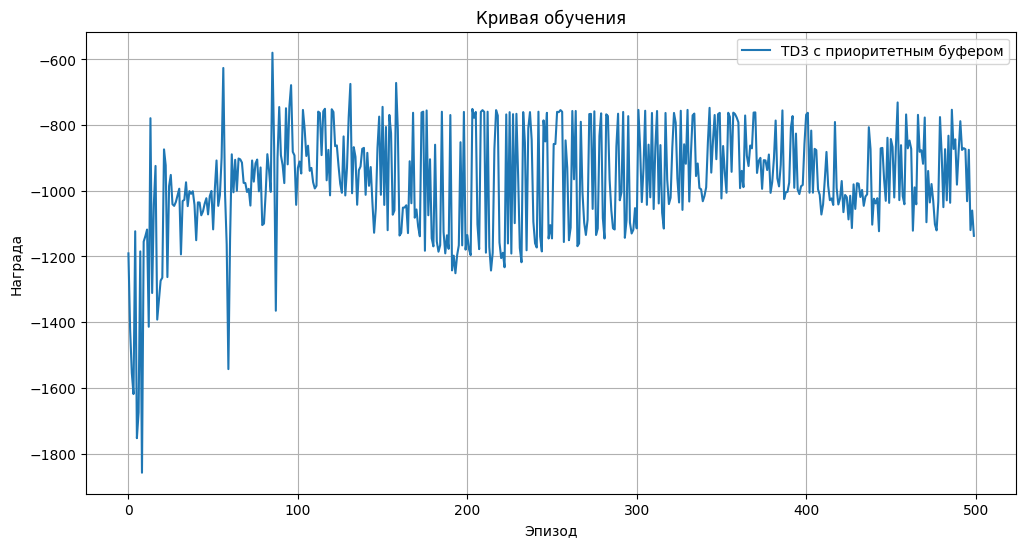

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from collections import deque
import random
from matplotlib import pyplot as plt

# Определение архитектуры нейронных сетей
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh()
        )
        self.max_action = max_action

    def forward(self, state):
        return self.max_action * self.net(state)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], 1))

# Приоритетный буфер воспроизведения опыта
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001):
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.capacity = int(capacity)
        self.buffer = []
        self.priorities = np.zeros(self.capacity)
        self.pos = 0
        self.max_priority = 1.0

    def __len__(self):
        return len(self.buffer)

    def add(self, transition):
        if len(transition) != 5:  # Проверка формата (s, a, r, s', done)
            return
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.buffer) == 0:
            return [], [], []
        priorities = self.priorities[:len(self.buffer)]
        probs = priorities ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        weights = (len(self.buffer) * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        samples = [self.buffer[i] for i in indices]
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            if idx < len(self.buffer):
                self.priorities[idx] = priority
        self.max_priority = max(self.priorities.max(), self.max_priority)
        self.beta = min(1.0, self.beta + self.beta_increment)

# Агент TD3 с ансамблем критиков
class TD3Agent:
    def __init__(self, state_dim, action_dim, max_action, num_critics=2):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critics = [Critic(state_dim, action_dim) for _ in range(num_critics)]
        self.critics_target = [Critic(state_dim, action_dim) for _ in range(num_critics)]
        for c_target, c in zip(self.critics_target, self.critics):
            c_target.load_state_dict(c.state_dict())
        self.critic_optimizers = [optim.Adam(c.parameters(), lr=3e-4) for c in self.critics]

        self.max_action = max_action
        self.tau = 0.005
        self.gamma = 0.99
        self.policy_noise = 0.2
        self.noise_clip = 0.5
        self.policy_freq = 2
        self.total_it = 0

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        return self.actor(state).squeeze().detach().numpy()

    def update(self, buffer, batch_size=256):
        self.total_it += 1
        samples, indices, weights = buffer.sample(batch_size)
        if len(samples) == 0:
            return

        # Распаковка данных
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for sample in samples:
            states.append(sample[0])
            actions.append(sample[1])
            rewards.append(sample[2])
            next_states.append(sample[3])
            dones.append(sample[4])

        # Конвертация в тензоры
        state = torch.FloatTensor(np.array(states))
        action = torch.FloatTensor(np.array(actions))
        reward = torch.FloatTensor(np.array(rewards)).unsqueeze(1)
        next_state = torch.FloatTensor(np.array(next_states))
        done = torch.FloatTensor(np.array(dones)).unsqueeze(1)
        weights = torch.FloatTensor(weights).unsqueeze(1)

        # Обновление критиков
        with torch.no_grad():
            noise = (torch.randn_like(action) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)

            target_Q1 = self.critics_target[0](next_state, next_action)
            target_Q2 = self.critics_target[1](next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (1 - done) * self.gamma * target_Q

        critic_losses = []
        current_Qs = []
        for critic, optimizer in zip(self.critics, self.critic_optimizers):
            current_Q = critic(state, action)
            current_Qs.append(current_Q)
            critic_loss = (weights * (current_Q - target_Q).pow(2)).mean()
            optimizer.zero_grad()
            critic_loss.backward()
            optimizer.step()
            critic_losses.append(critic_loss.item())

        # Обновление актора и целевых сетей
        if self.total_it % self.policy_freq == 0:
            actor_loss = -self.critics[0](state, self.actor(state)).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Мягкое обновление
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for critic, critic_target in zip(self.critics, self.critics_target):
                for param, target_param in zip(critic.parameters(), critic_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        # Обновление приоритетов
        td_errors = (current_Qs[0] - target_Q).abs().squeeze().detach().numpy()
        buffer.update_priorities(indices, td_errors + 1e-5)

# Функция обучения
def train(env_name="Pendulum-v1", episodes=200):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = TD3Agent(state_dim, action_dim, max_action)
    buffer = PrioritizedReplayBuffer(capacity=100000)
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        while True:
            action = agent.select_action(state)

            # Явное преобразование действия в numpy array
            action = np.array(action, dtype=np.float32).reshape(-1)  # Важно: (action_dim,)

            try:
                # Шаг среды
                step_result = env.step(action)
                print("Step result:", step_result)  # Отладочный вывод
                next_state, reward, terminated, truncated, info = step_result
            except Exception as e:
                print(f"Ошибка в env.step(): {e}")
                raise

            done = terminated or truncated

            # Преобразование в списки
            buffer.add((
                np.array(state).flatten().tolist(),    # Гарантированно список
                action.tolist(),
                float(reward),
                np.array(next_state).flatten().tolist(),
                float(done)
            ))

            total_reward += reward
            state = np.array(next_state).copy()  # Копирование массива

            if len(buffer) >= 256:
                agent.update(buffer, 256)

            if done:
                break

        rewards.append(total_reward)
        print(f"Episode: {episode+1}, Reward: {total_reward:.2f}")

    return rewards

# Визуализация результатов
def plot_results(rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='TD3 с приоритетным буфером')
    plt.xlabel("Эпизод")
    plt.ylabel("Награда")
    plt.title("Кривая обучения")
    plt.grid(True)
    plt.legend()
    plt.savefig("learning_curve.png")
    plt.show()

if __name__ == "__main__":
    rewards = train(episodes=500)
    plot_results(rewards)

1. TD3 показывает более стабильное обучение благодаря двойным критикам и задержанным обновлениям.

2. Приоритетный буфер ускоряет обучение, фокусируясь на важных переходах.

3. Ансамбль критиков (3+) не дает значительных улучшений, увеличивая вычислительные затраты.